In [42]:
#Импорт библиотек
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
#Загрузка данных
data = yf.download('NVDA', start='2020-01-01', end='2024-01-01')
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']
data['Price_Change'] = data['Close'].diff()
data.fillna(data.bfill(),inplace=True)
data.fillna(data.ffill(), inplace=True)

[*********************100%***********************]  1 of 1 completed


In [45]:
# Подготовка признаков
features = ['Close', 'SMA_10', 'SMA_20', 'EMA_10', 'Volatility', 'Price_Change']
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

data[features] = feature_scaler.fit_transform(data[features])
data['Close'] = target_scaler.fit_transform(data[['Close']])


In [46]:
# Формирование последовательностей
sequence_length = 60
X, y = [], []
for i in range(len(data) - sequence_length):
    X.append(data[features].iloc[i:i+sequence_length].values)
    y.append(data['Close'].iloc[i+sequence_length])

X = np.array(X)
y = np.array(y)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [48]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [49]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
        self.fc2 = nn.Sequential(
            nn.Linear(d_model, 1),
            nn.Sigmoid())

    
    def forward(self, x):
        # Входные данные: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # Перестановка для трансформера: (seq_len, batch_size, d_model)
        x = self.transformer(x)  # (seq_len, batch_size, d_model)
        x = x[-1]  # Используем только последнее значение (batch_size, d_model)
        x = self.fc(x)  # (batch_size, 1)
        x = self.fc2(x)
        return x

In [50]:
input_dim = X_train.shape[2]
d_model = 256
n_heads = 4
num_layers = 2
dropout = 0.2
lr = 0.001
epochs = 6
batch_size = 64

model = TimeSeriesTransformer(input_dim, d_model, n_heads, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [51]:
# Обучение
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 256x1)

In [ ]:
# Оценка на тестовых данных
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss:.4f}")


Test Loss: 1.5660


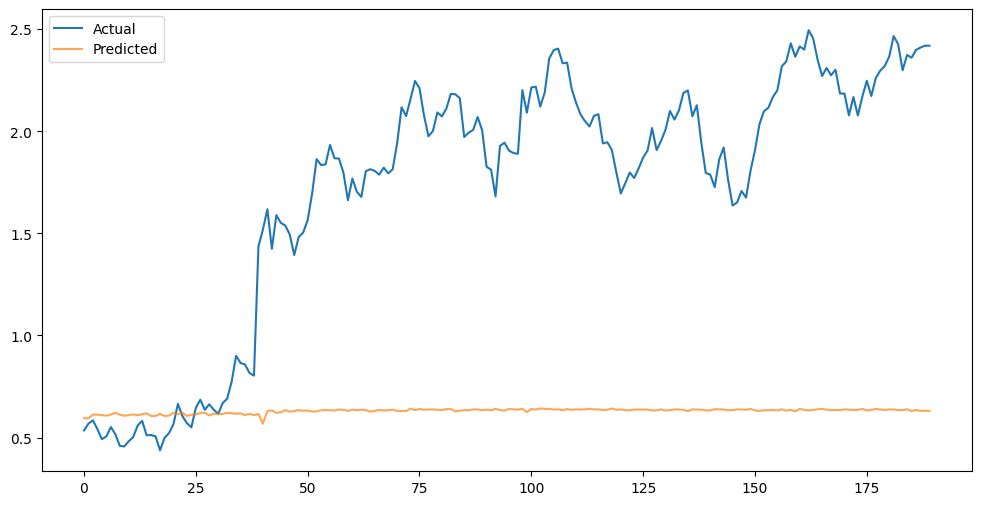

Predictions (rescaled): [[0.5953951 ]
 [0.59347343]
 [0.612633  ]
 [0.6120077 ]
 [0.60982555]
 [0.6073421 ]
 [0.6123255 ]
 [0.6212682 ]
 [0.6119831 ]
 [0.60725504]
 [0.6095306 ]
 [0.6131942 ]
 [0.60958594]
 [0.61446863]
 [0.6186083 ]
 [0.6058023 ]
 [0.605825  ]
 [0.61603814]
 [0.60551316]
 [0.6076401 ]
 [0.62115663]
 [0.61384314]
 [0.6214238 ]
 [0.60600895]
 [0.61185837]
 [0.61384606]
 [0.6196783 ]
 [0.6214613 ]
 [0.60857695]
 [0.61695296]]
Actual (rescaled): [[0.5349139 ]
 [0.56844944]
 [0.5844511 ]
 [0.5408719 ]
 [0.49218607]]


In [ ]:
# Преобразование прогнозов обратно в исходный масштаб
predicted = target_scaler.inverse_transform(predictions.numpy().reshape(-1, 1))
actual = target_scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
#Построение графика
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted', alpha=0.7)
plt.legend()
plt.show()

# Вывод первых значений для проверки
print("Predictions (rescaled):", predicted[:30])
print("Actual (rescaled):", actual[:5])
